# E大门票股

- 作者：DGC'Idea
- 版本：V0.1   
- 更新日期：2018年4月6日

----------
- 市盈率PE<30（保证不会为了“成长”付出太大的价格）；
- 连续五年，每季度净利润环比增长率>0（保证买到的不是便宜但毫无成长性的股票）；
- PEG<1，即市盈率小于五年净利润符合增长率，同时小于最近一个报告期的净利润增长率（保证成长大于估值）；。
- 净资产收益率ROE>10%。

In [1]:
#导入库
import numpy as np
import pandas as pd
import time
from datetime import timedelta,date

import jqdata

#引入自定义库
import sys
sys.path.append('/home/jquser')
from pf_stk import *


#生成对象
ed=Stk('csv','../Data/','edticket')  


个股模块：运行于研究


## 1.股票池

## 1.1.生成股票池

In [8]:
#筛选.E大门票股
def pool(codes='000902.XSHG',stat_year=2017,max_year=5,max_pe=30,max_peg=1.01,max_roe=10,max_qnet=18):
    #初选股票池列表
    pool_list=[]
    #获取沪深所有股票
    stocks=get_index_stocks(codes)

    #股票总数量
    n=len(stocks)
    #计数器
    m=0
    for code in stocks:
        #计数器累加
        m=m+1
        #股票名称
        stock_name=get_security_info(code).display_name       
        #转换代码
        stock_code=code[0:6]
        #IPO日期
        ipo_date=get_security_info(code).start_date
        #转换ipo日期
        ipo_year=int(ipo_date.strftime('%Y'))
        #显示进度
        print '\r股票筛选：%s %s %s/%s'%(stock_code,stock_name,m,n),
        #剔除退市、ST
        if is_st(code):
            continue
        #剔除未满5年   
        if (stat_year-ipo_year+1)<max_year:
            continue 
        #判断是否已出最新年报    
        if not is_report(code,stat_year):
            continue 
        #剔除pe>30
        (pe,pb,ps,market_cap)=get_stock_valuation(code)
        if pe>max_pe or pe<0:
            continue 
        #剔除peg>1 
        (roe,roe_mean,gross_profit,inc_revenue,net_profit,new_profit,df)=get_stock_indicator(code,stat_year,max_year)
        peg=round(pe/net_profit,2)
        if (pe>net_profit) or (pe>new_profit) or (peg>max_peg):
            continue  
        #剔除roe<10% 
        if (roe<max_roe):
            continue     
        #连续5年，每个季度利润都在增长     
        qnet=get_stock_qnet(code,stat_year,max_year)
        if qnet<max_qnet:
            continue 
        #股息率
        dyr=round(ed.data.get_divid(code,'2018-07-30')[0],2)
        #获取所属行业名称
        industry=get_stock_industry(code)    
        #拼接列表
        pool_list.append([code,stock_name,pe,pb,ps,roe,dyr,peg,net_profit,new_profit,market_cap,
                          industry,ipo_date]) 
    #整理标题头
    columns_list=['code','name',
                  'pe','pb','ps','roe','dyr','peg','net_profit','new_profit_grow','market_cap',
                  'industry','ipo_date']
    #组织数据
    df=pd.DataFrame(data=pool_list,columns=columns_list)
    #设置索引为股票代码
    df.set_index(['code'],inplace=True)
    df.index.name=None
    df=df.sort(['pe'],ascending=False)
    #返回结果        
    return df  


#净利润环比增长率
def get_stock_qnet(code,stat_year=2017,max_year=5):
    q=query(
        indicator.inc_net_profit_annual,
        indicator.inc_net_profit_year_on_year,
        indicator.inc_operation_profit_annual,
    ).filter(
        indicator.code==code
    )
    df=pd.DataFrame()
    #获取近五年每季度的净利润环比增长率
    for j in range(0,max_year):
        for i in range(1,max_year):
            rets=get_fundamentals(q,statDate=str(stat_year-j)+'q'+str(i))
            df=pd.concat([df,rets],axis=0)
#     print df['inc_net_profit_annual']
    return len(df[df['inc_net_profit_annual']>0])


#     stocks=[
#         '601288.XSHG',
#             '601818.XSHG','601998.XSHG','601398.XSHG','601939.XSHG',
#             '000001.XSHE','601390.XSHG','601186.XSHG',
#             '002142.XSHE',
#            '600036.XSHG','600741.XSHG','600987.XSHG','601318.XSHG','600373.XSHG','000423.XSHE','600511.XSHG',
#            '002449.XSHE','600332.XSHG','002372.XSHE','600009.XSHG','300144.XSHE','600438.XSHG','600340.XSHG',
#            ]
#     stocks=['600332.XSHG']

#筛选股票

df=ed.pool.create(pool,codes='000300.XSHG',stat_year=2017,
                            max_year=5,max_pe=30,max_peg=1.00,max_roe=10,max_qnet=15)
df

股票筛选：603993 洛阳钼业 300/300 


### 1.2.查看股票池

In [9]:
ed.pool.show()

,名称,PE-TTM,PB,PS,ROE,股息率,PEG,净利润(千万),最新利增(%),自由流通总市值(亿),所属行业,IPO日期
002450,康得新,22.84,4.79,3.22,14.32,0.33,0.54,42.20,26.06,494.04,化工I,2010-07-16
600690,青岛海尔,14.58,0.64,3.33,19.20,2.00,0.89,16.41,37.37,1045.09,家用电器I,1993-11-19
601012,隆基股份,12.12,2.59,3.23,28.53,0.81,0.06,189.72,130.38,440.60,电气设备I,2012-04-11
600309,万华化学,11.11,2.49,5.19,50.88,2.96,0.18,60.90,202.62,1387.51,化工I,2000-01-05
600019,宝钢股份,9.30,0.67,1.19,12.59,5.28,0.06,167.05,111.22,1883.01,钢铁I,2000-12-12


## 2.获取数据
1. 获取股票日线数据，包括行情数据、估值数据。

In [3]:
#获取股票池数据
last_date=get_stock_data(id)

-数据获取完成！


## 3.数据分析
- 估值分析：PE-TTM（滚动市盈率）、PB（平均市净率）；
- 财务指标分析：毛利率、ROE（年报、扣非后净资产收益率）、近五年或三年的平均ROE、近三年营业收入复合增长率、近三年净利润复合增长率、股息率、PEG。

In [5]:
#数据分析
df=get_stock_analysis(last_date,id)

-数据分析完成！


### 3.1.PE估值表
- PE-TTM：滚动市盈率，为近五年的数据；
- 高度：表示时间窗内（五年），低于当前值的个数与全部样本个数的比例，代表当前值在历史统计值的估值位置；
- 最小值：表示时间窗内（五年）理论最小估值，表示其估值下限；
- 最大值：表示时间窗内（五年）理论最大估值，表示其估值上限；
- 中位数：表示时间窗内（五年），代表该指数的理论合理估值；
- 距底：表示当前值与最低值的距离，代表最大的可能跌幅。 

In [6]:
#获取pe估值表
df=show_pe_table(id)
#显示估值表
df

,名称,PE-TTM,高度%,最低,最高,中位,距底%,计算起点,样本数
002449,国星光电,23.35,1.23,20.00,105.49,37.845,-14.35,2013-04-08,1218
600438,通威股份,20.74,5.25,17.70,58.09,29.315,-14.66,2013-04-08,1218
600340,华夏幸福,10.82,8.13,8.85,25.16,13.740,-18.21,2013-04-08,1218
600332,白云山,23.25,10.84,20.13,118.60,30.170,-13.42,2013-04-08,1218
601186,中国铁建,8.26,32.51,4.57,29.46,10.610,-44.67,2013-04-08,1218
601390,中国中铁,10.48,33.00,5.29,46.28,13.780,-49.52,2013-04-08,1218
601318,中国平安,13.25,66.50,8.73,21.13,11.470,-34.11,2013-04-08,1218
002142,宁波银行,10.12,85.88,4.94,13.21,8.430,-51.19,2013-04-08,1218


### 3.2.PB估值表
- PB：平均市净率，为近五年的数据；
- 其它指标同PE。

In [7]:
#获取pb估值表
df=show_pb_table(id)
#显示估值表
df

,名称,PB,高度%,最低,最高,中位,距底%,计算起点,样本数
600340,华夏幸福,3.38,9.11,2.92,8.67,4.415,-13.61,2013-04-08,1218
600332,白云山,2.54,14.70,2.14,11.90,4.430,-15.75,2013-04-08,1218
601186,中国铁建,0.98,31.94,0.59,3.54,1.220,-39.80,2013-04-08,1218
601390,中国中铁,1.17,34.40,0.57,4.60,1.410,-51.28,2013-04-08,1218
600438,通威股份,3.13,37.85,1.71,8.32,3.285,-45.37,2013-04-08,1218
002449,国星光电,2.66,77.42,1.36,5.78,2.280,-48.87,2013-04-08,1218
601318,中国平安,2.49,85.88,1.39,3.21,1.750,-44.18,2013-04-08,1218
002142,宁波银行,1.88,96.14,0.86,2.16,1.310,-54.26,2013-04-08,1218


### 3.3.财务指标表
- 毛利率：毛利与销售收入（或营业收入）的百分比；
- ROE：净资产收益率（年报、扣非后）；
- ROE均：近五年或三年的平均ROE； 
- 营复增：近三年营业收入复合增长率；
- 利复增：近三年净利润复合增长率；
- 股息率：加权股息率； 
- PEG：PE/G，G为近三年利复增
- 说明：用近三年的数据而不是近五年的数据计算净复增，是为了更好地反应企业近期的盈利情况。

In [8]:
#获取财务信息表
df=show_finance_table(id)
#显示表
df

,名称,毛利率%,ROE%,ROE均%,营复增%,利复增%,股息率%,股息率均%,PEG,价格,市值(亿),涨幅%,涨跌,IPO日期
601186,中国铁建,9.24,10.53,11.48,7.25,13.42,1.51,1.39,0.62,9.77,1438.71,-0.51,-0.05,2013-04-08
002449,国星光电,23.67,10.65,6.25,29.97,66.19,1.15,1.09,0.35,17.63,82.40,-1.73,-0.31,2013-04-08
601390,中国中铁,9.38,10.68,9.74,7.52,12.16,1.14,1.09,0.86,7.37,1766.92,-0.27,-0.02,2013-04-08
600332,白云山,37.66,10.69,12.91,12.74,22.88,0.92,0.84,1.02,29.48,494.22,0.37,0.11,2013-04-08
600438,通威股份,19.42,15.68,13.22,8.31,78.48,0.66,1.36,0.26,10.75,470.16,2.28,0.24,2013-04-08
002142,宁波银行,NaN,17.42,17.92,19.81,18.13,1.51,2.32,0.56,18.64,902.92,-0.32,-0.06,2013-04-08
601318,中国平安,NaN,20.81,17.68,24.54,30.58,1.52,1.26,0.43,64.55,12645.15,0.06,0.04,2013-04-08
600340,华夏幸福,47.93,26.49,37.54,39.17,36.61,2.10,1.46,0.30,32.16,927.56,-0.34,-0.11,2013-04-08


### 3.4.综合表
- 估值、财务指标综合对比。

In [9]:
#获取综合表
df=show_integrate_table(id)
#显示表
df

,名称,PE,PE高度%,PB,PB高度%,毛利率%,ROE%,ROE均%,营复增%,利复增%,股息率%,股息率均%,PEG,所属行业
002142,宁波银行,10.12,85.88,1.88,96.14,NaN,17.42,17.92,19.81,18.13,1.51,2.32,0.56,银行I
601318,中国平安,13.25,66.50,2.49,85.88,NaN,20.81,17.68,24.54,30.58,1.52,1.26,0.43,非银金融I
601390,中国中铁,10.48,33.00,1.17,34.40,9.38,10.68,9.74,7.52,12.16,1.14,1.09,0.86,建筑装饰I
601186,中国铁建,8.26,32.51,0.98,31.94,9.24,10.53,11.48,7.25,13.42,1.51,1.39,0.62,建筑装饰I
600332,白云山,23.25,10.84,2.54,14.70,37.66,10.69,12.91,12.74,22.88,0.92,0.84,1.02,医药生物I
600340,华夏幸福,10.82,8.13,3.38,9.11,47.93,26.49,37.54,39.17,36.61,2.10,1.46,0.30,房地产I
600438,通威股份,20.74,5.25,3.13,37.85,19.42,15.68,13.22,8.31,78.48,0.66,1.36,0.26,农林牧渔I
002449,国星光电,23.35,1.23,2.66,77.42,23.67,10.65,6.25,29.97,66.19,1.15,1.09,0.35,电子I


### 3.5.价格行情表

## 4.图表分析
1. PE、价格对比图；
2. PB、价格对比图；
3. ROE、价格对比图；

### 4.1.PE与价格对比图
- PE与价格对比折线图，左侧Y轴为PE、右侧Y轴为价格。

生成图表: sh600332 白云山 

/opt/conda/envs/python2/lib/python2.7/site-packages/dateutil/parser.py:83: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  while nextchar == '\x00':
/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


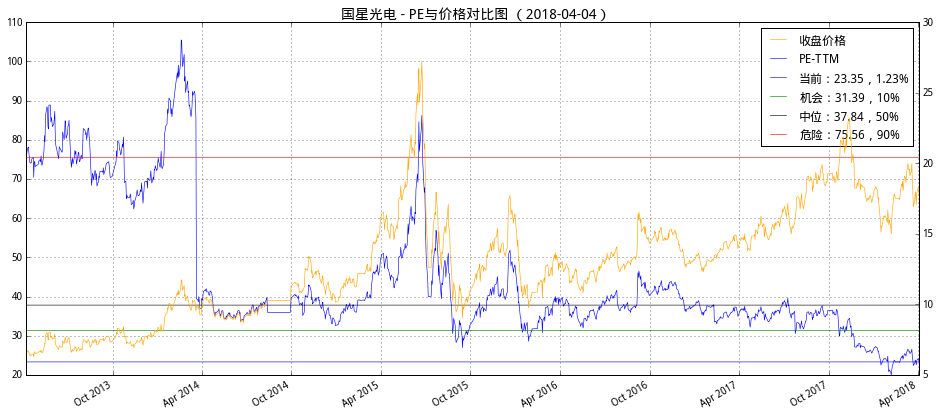

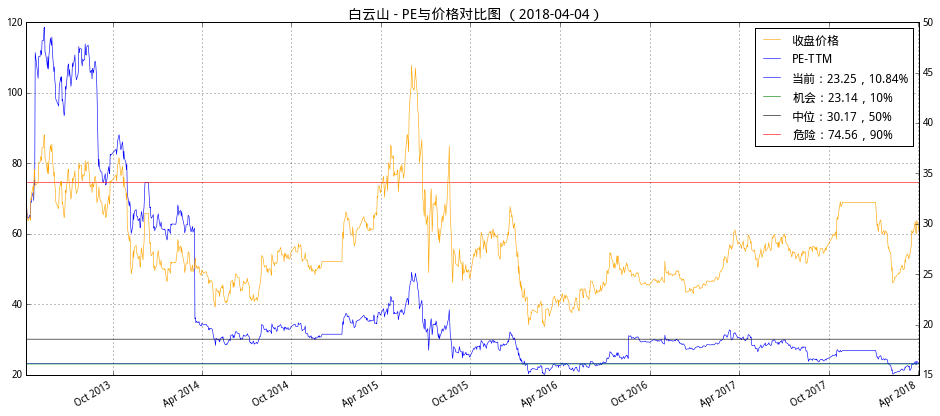

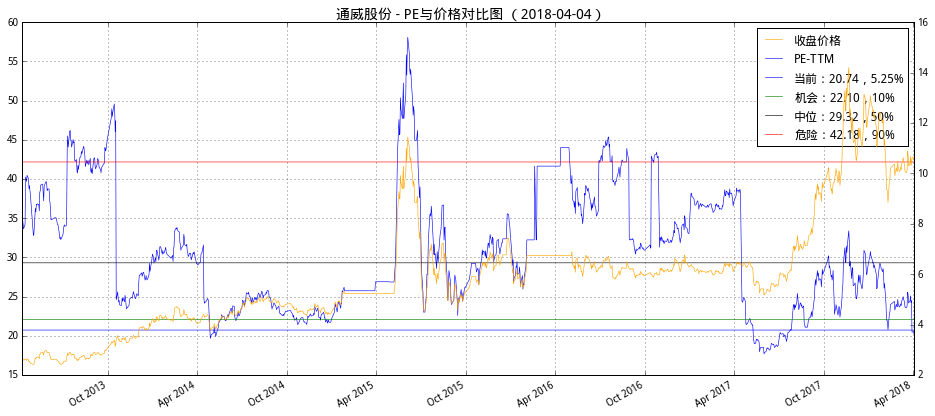

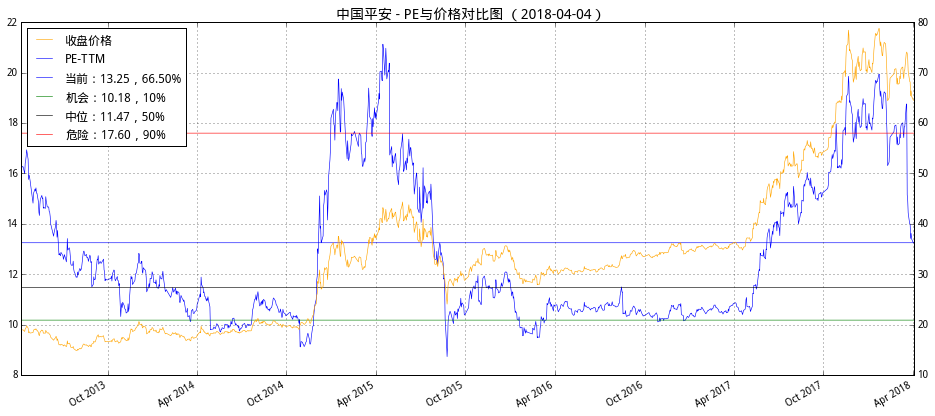

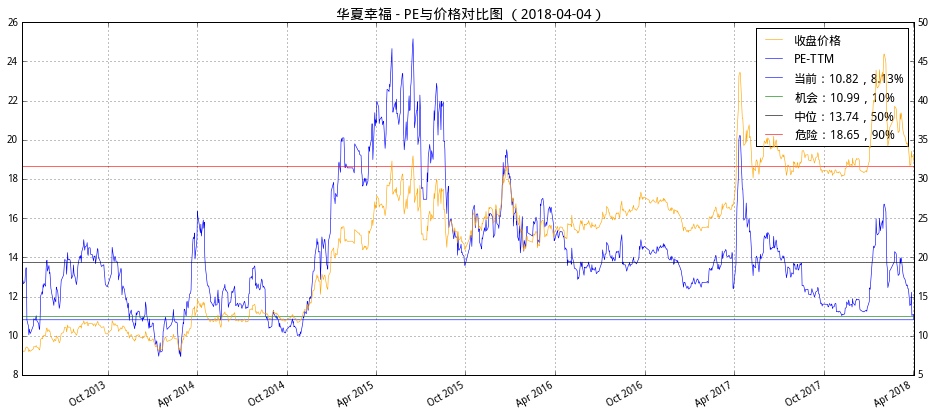

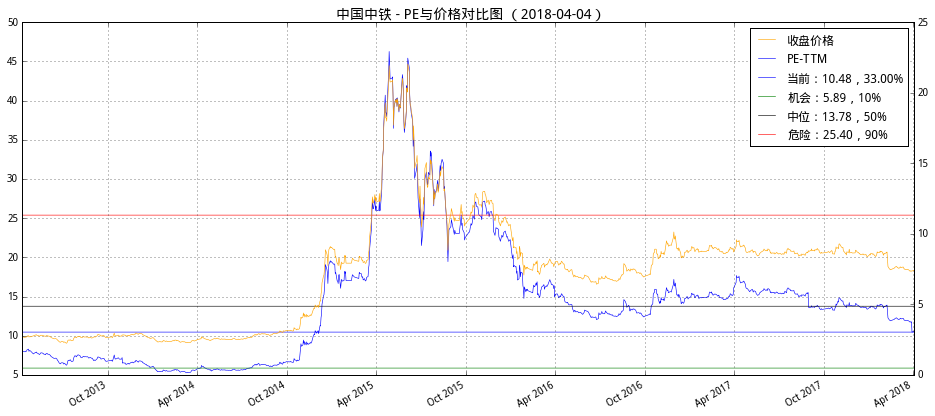

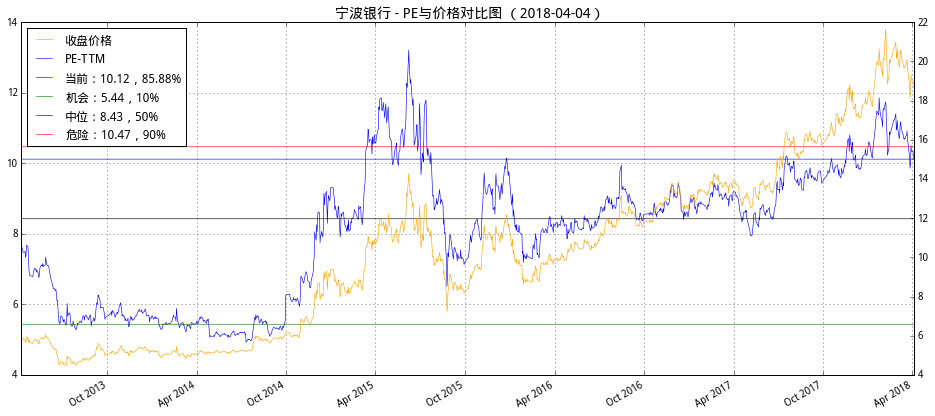

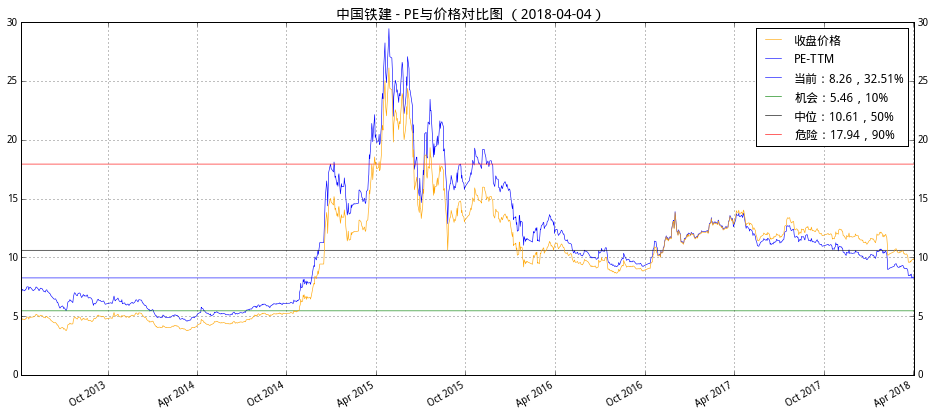

In [113]:
#获取PE图表
plot_pe_chart(id)

### 4.2.PB与价格对比图
- PB与价格对比折线图，左侧Y轴为PB、右侧Y轴为价格。

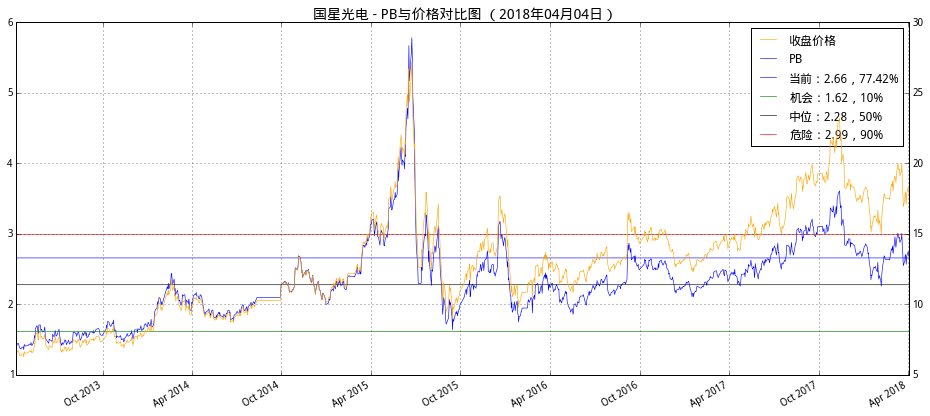

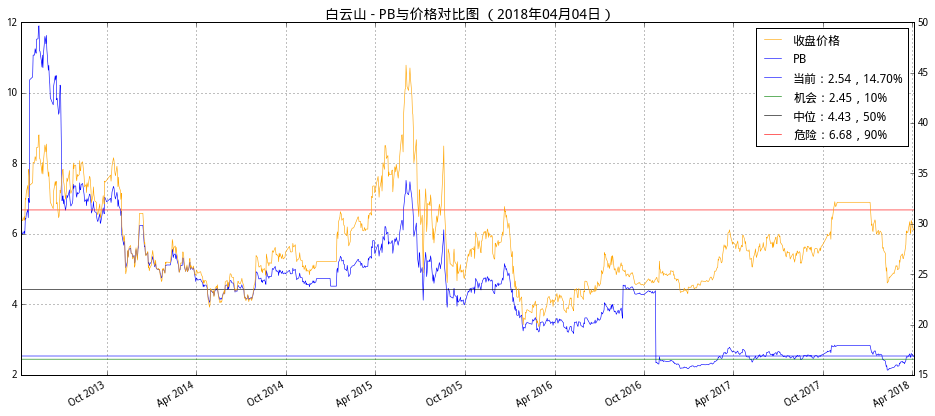

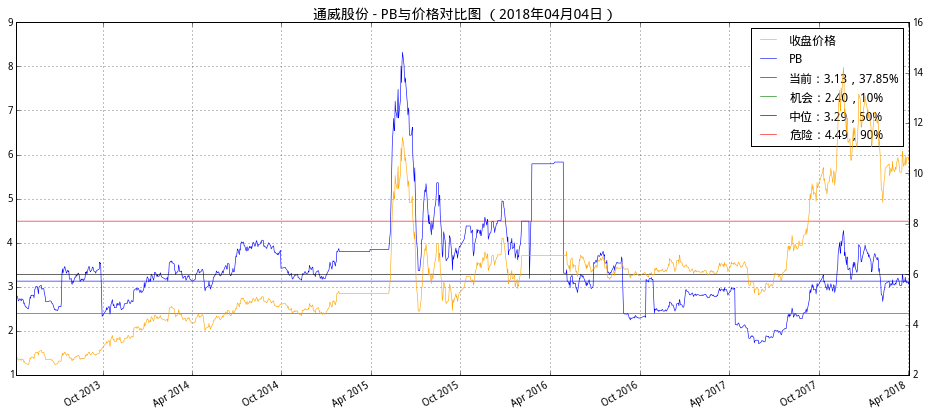

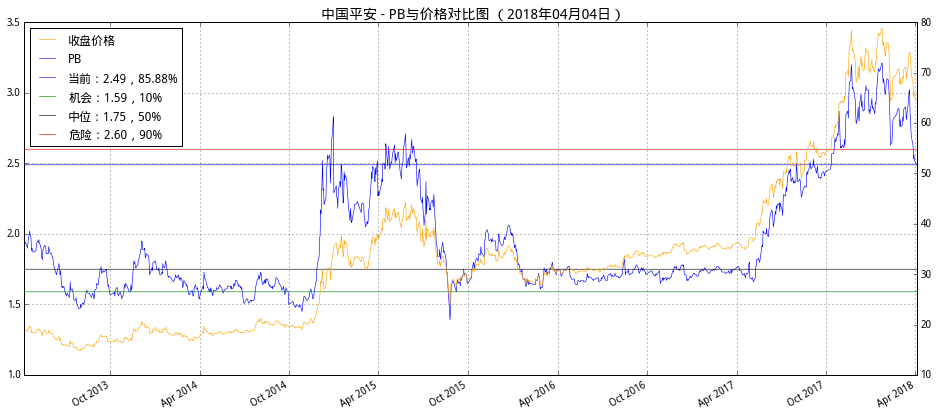

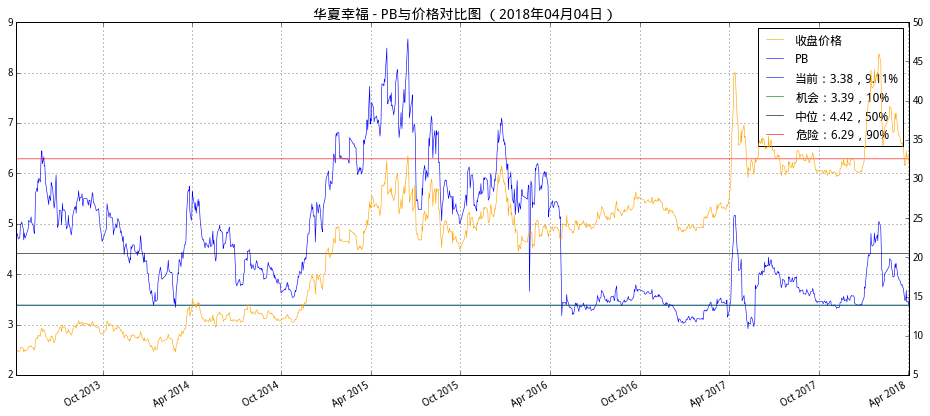

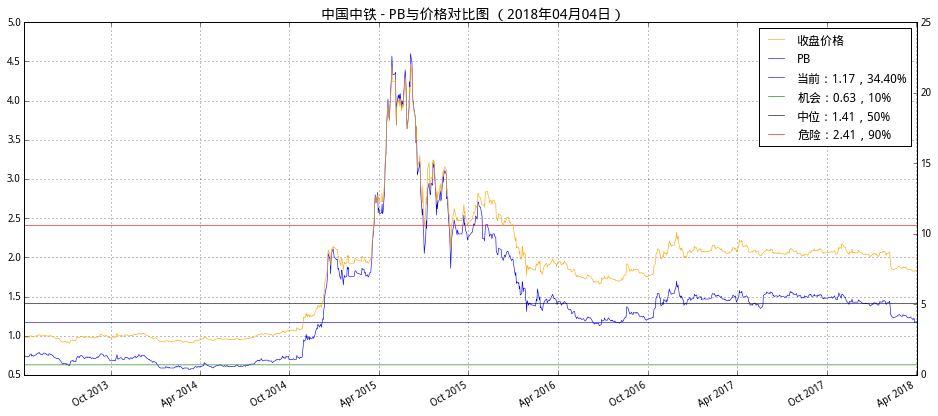

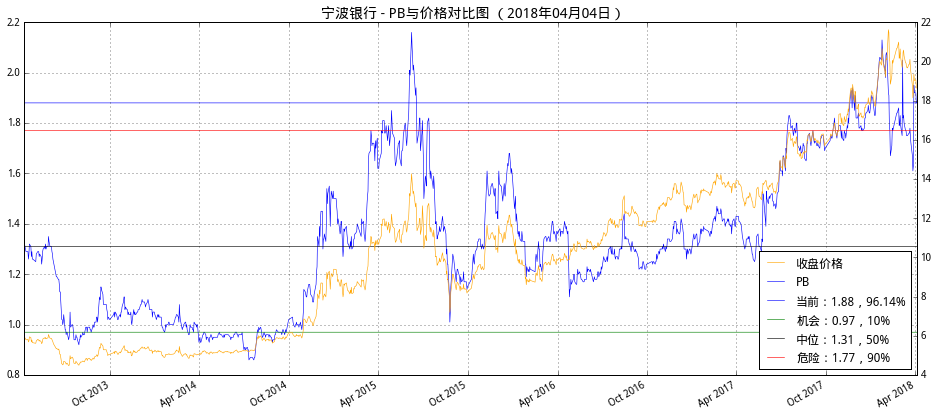

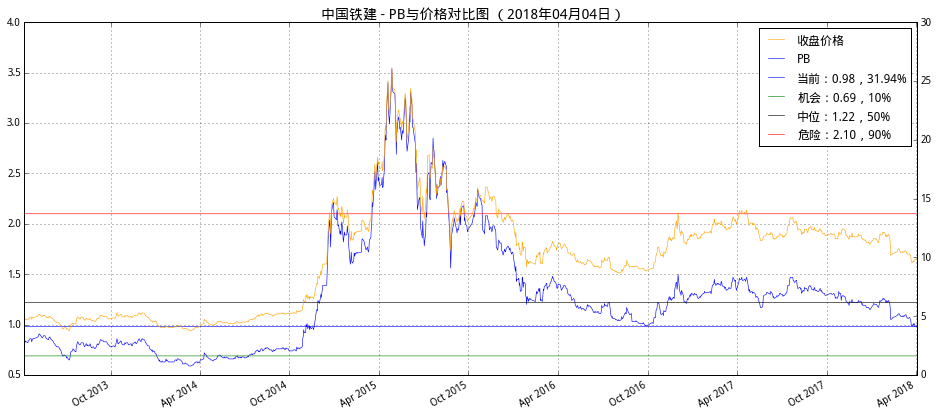

In [122]:
#获取PB图表  
plot_pb_chart(id)     

### 4.3.ROE与价格对比图
- ROE与价格对比折线图，左侧Y轴为ROE、右侧Y轴为价格。

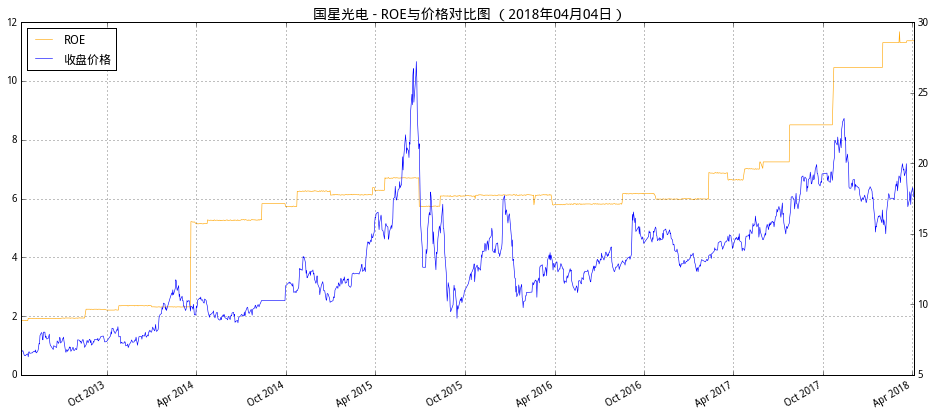

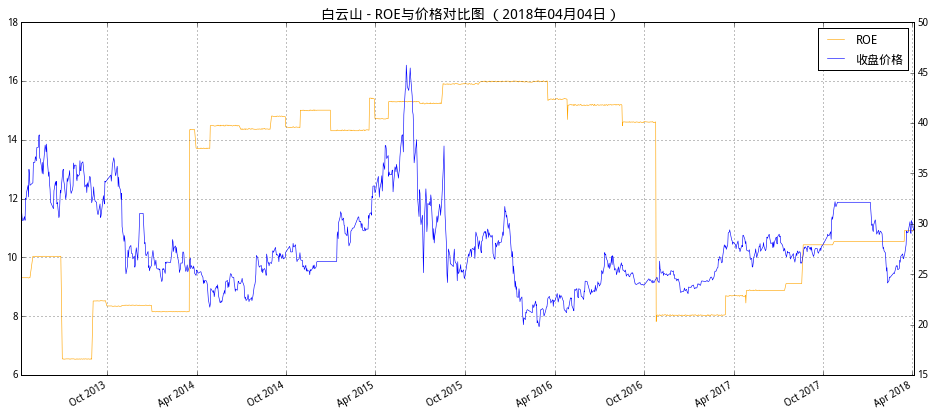

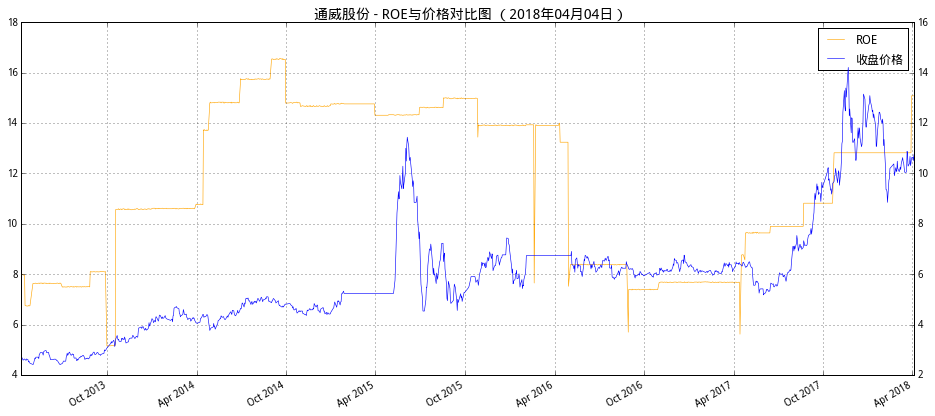

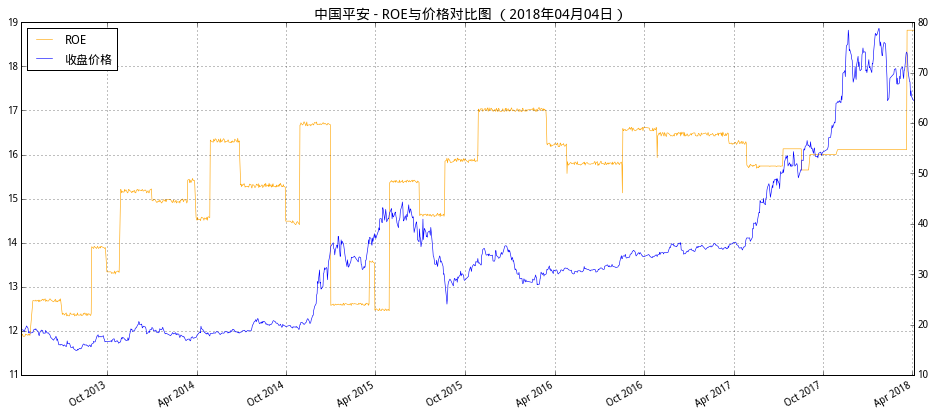

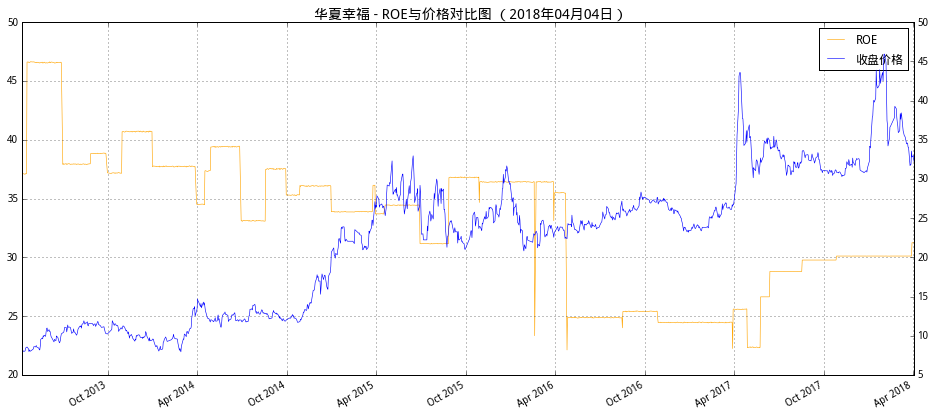

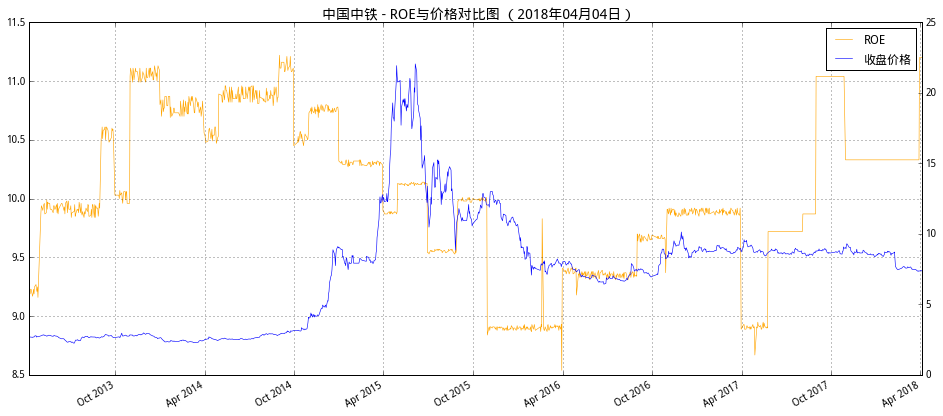

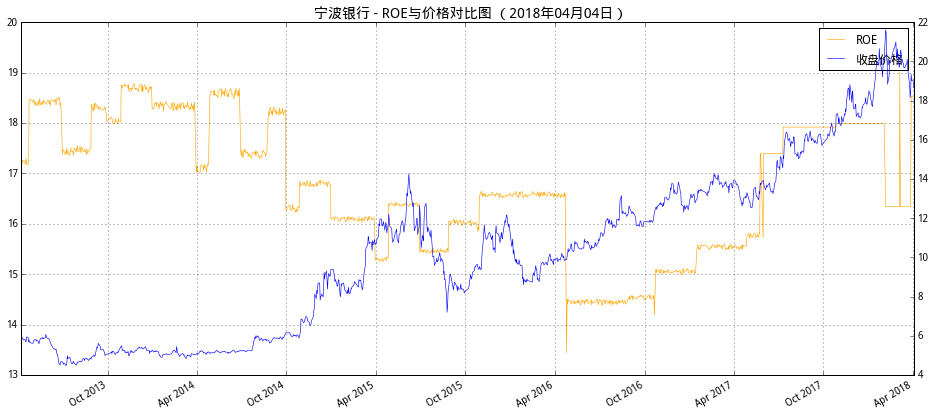

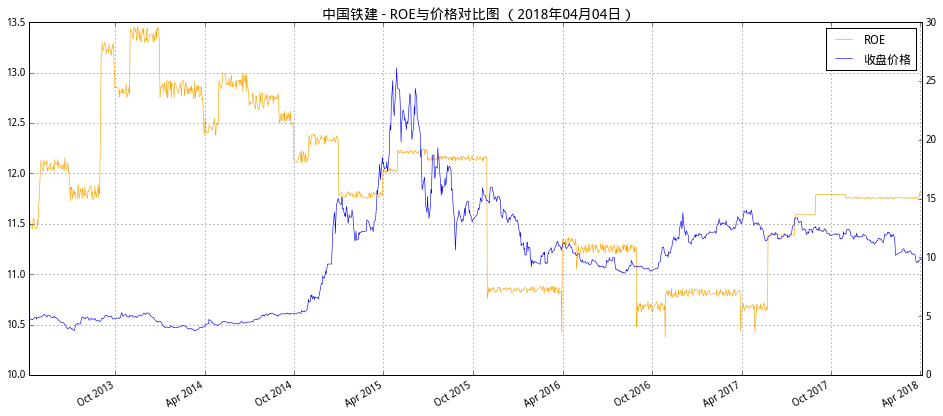

In [123]:
plot_roe_chart(id)   